In [1]:
cd ..

d:\research\fedmiss_bench


In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from src.loaders.load_data import load_data
from collections import OrderedDict
import numpy as np

## Functions

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_heatmap(df, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(), annot=True, fmt=".2f")
    plt.show()

In [4]:
def avg_correlation(df):
    avg_correlation_cols = list(OrderedDict(df.corr().abs().mean().sort_values(ascending=False).to_dict()).items())
    features = set(df.columns.tolist()[:-1])
    avg_correlation_cols = [col for col in avg_correlation_cols if col[0] in features]
    return avg_correlation_cols

## Codrna

m:\miniconda3\envs\fed_imp2\lib\site-packages\dython\nominal.py:298: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


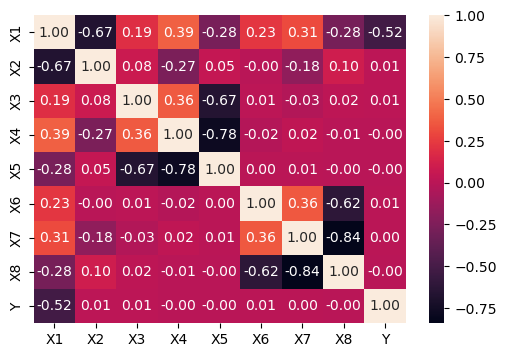

[('X1', 0.429489880213649), ('X8', 0.31901145615536025), ('X4', 0.3163901984059654), ('X5', 0.3089736284690783), ('X7', 0.30531752367756965), ('X3', 0.26361469337490206), ('X2', 0.26206371049527105), ('X6', 0.25082064648896907)]
{'target': 'Y', 'important_features_idx': [0], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7], 'num_cols': 8, 'task_type': 'classification', 'clf_type': 'binary-class', 'data_type': 'tabular', 'split_cols': [0]}


In [5]:
df, data_config = load_data('codrna')
show_heatmap(df,  figsize = (6,4))
print(avg_correlation(df))
data_config['split_cols'] = [0]
print(data_config)

## HHP

In [26]:
############################################################################################################
# Load data
# members
df_members = pd.read_csv('./data/HHP_herritage_health/Members.csv')
df_members['Sex'] = df_members['Sex'].map({'M': 1, 'F': 0})
df_members['AgeAtFirstClaim'] = df_members['AgeAtFirstClaim'].map({
    '0-9': 5,
    '10-19': 15,
    '20-29': 25,
    '30-39': 35,
    '40-49': 45,
    '50-59': 55,
    '60-69': 65,
    '70-79': 75,
    '80+': 90
})

# drug and lab
df_drug = pd.read_csv('./data/HHP_herritage_health/DrugCount.csv')
df_drug['DrugCount'] = df_drug['DrugCount'].map({'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7+': 10})
df_lab = pd.read_csv('./data/HHP_herritage_health/LabCount.csv')
df_lab['LabCount'] = df_lab['LabCount'].map(
    {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10+': 12}
)

# days
df_days_y2 = pd.read_csv('./data/HHP_herritage_health/DaysInHospital_Y2.csv')
df_days_y2['Year'] = 'Y1'
df_days_y3 = pd.read_csv('./data/HHP_herritage_health/DaysInHospital_Y3.csv')
df_days_y3['Year'] = 'Y2'

df_days = pd.concat([df_days_y2, df_days_y3])

df_claims = pd.read_csv('./data/HHP_herritage_health/Claims.csv')

# divide by provider
# providers = df_claims['ProviderID'].value_counts().iloc[: 10].index.tolist()
# df_claims = df_claims[df_claims['ProviderID'].isin(providers)]
# print(df_claims.shape)

df_claims = pd.merge(df_claims, df_members, on='MemberID', how='left')
df_claims = pd.merge(df_claims, df_drug, on=['MemberID', 'Year', 'DSFS'], how='left')
df_claims = pd.merge(df_claims, df_lab, on=['MemberID', 'Year', 'DSFS'], how='left')
df_claims = pd.merge(df_claims, df_days, on=['MemberID', 'Year'], how='left')
df_claims = df_claims[df_claims['DaysInHospital'].notna()]
print(df_claims.shape)

#################################################################################################################
# Feature engineering
# drop missing age and sex
df_claims = df_claims[df_claims['AgeAtFirstClaim'].notna()]
df_claims = df_claims[df_claims['Sex'].notna()]
df_claims = df_claims[df_claims['DSFS'].notna()]

# transform categorical columns
def transform1(row):
    if pd.isna(row):
        return 'None'
    else:
        return str(int(row))
    
df_claims['ProviderID'] = df_claims['ProviderID'].map(transform1)
df_claims['Vendor'] = df_claims['Vendor'].map(transform1)
df_claims['PCP'] = df_claims['PCP'].map(transform1)

# handle missing values for categorical columns
df_claims['ProcedureGroup'].fillna('None', inplace=True)
df_claims['Specialty'].fillna('None', inplace=True)
df_claims['PrimaryConditionGroup'].fillna('None', inplace=True)
df_claims['PlaceSvc'].fillna('None', inplace=True)

# encode number of columns
df_claims['CharlsonIndex'] = df_claims['CharlsonIndex'].map({'0': 0, '1-2': 1.5, '3-4': 3.5, '5+': 7})
df_claims['PayDelay'] = df_claims['PayDelay'].apply(lambda row: int(row) if row != '162+' else 200)
df_claims['LengthOfStay'] = df_claims['LengthOfStay'].map({
    '1 day': 1, '2 days': 2, '3 days': 3, '4 days': 4, '5 days': 5, '6 days': 6, '1- 2 weeks': 10, '2- 4 weeks': 21, '4- 8 weeks': 42,
})
df_claims['DSFS'] = df_claims['DSFS'].map({
    '0- 1 month': 1, '1- 2 months': 2, '2- 3 months': 3, '3- 4 months': 4, '4- 5 months': 5, '5- 6 months': 6, 
    '6- 7 months': 7, '7- 8 months': 8, '8- 9 months': 9, '9-10 months': 10, '10-11 months': 11, '11-12 months': 12
})

# filter all large claims
df_claims = df_claims[df_claims['DaysInHospital'] > 0]
print(df_claims.shape)

# fill mean values for drug and lab counts
df_claims['DrugCount'].fillna(df_claims['DrugCount'].mean(), inplace=True)
df_claims['LabCount'].fillna(df_claims['LabCount'].mean(), inplace=True)

# drop length of stay
df_claims = df_claims.drop(columns=['LengthOfStay'])

#########################################################################################################################
# Feature selection
# numerical features
def feature_agg(df, key):
    ret = df.groupby(['MemberID', 'Year']).agg(
        **{
            key+'_mean': pd.NamedAgg(column=key, aggfunc='mean'),
            key+'_std': pd.NamedAgg(column=key, aggfunc='std'),
            key+'_max': pd.NamedAgg(column=key, aggfunc='max'),
            key+'_min': pd.NamedAgg(column=key, aggfunc='min'),
        }
    )

    ret[f'{key}_range'] = ret[f'{key}_max'] - ret[f'{key}_min']
    ret = ret.reset_index()
    ret = ret.drop(columns=[f'{key}_min'])
    
    df = pd.merge(df, ret, on=['MemberID', 'Year'], how='left')
    df = df.drop(columns=[key])
    
    return df

df_claims = feature_agg(df_claims, 'DSFS')
df_claims = feature_agg(df_claims, 'PayDelay')
df_claims = feature_agg(df_claims, 'CharlsonIndex')
df_claims = feature_agg(df_claims, 'DrugCount')
df_claims = feature_agg(df_claims, 'LabCount')

def feature_agg2(df, key):
    df = df.groupby(['MemberID', 'Year']).agg(key).nunique().reset_index(name = key+'_counts')
    df = pd.merge(df_claims, df, on = ['MemberID', 'Year'], how = 'left')
    return df

df_claims = feature_agg2(df_claims, 'ProviderID')
df_claims = feature_agg2(df_claims, 'Vendor')
df_claims = feature_agg2(df_claims, 'PCP')
df_claims = feature_agg2(df_claims, 'Specialty')
df_claims = feature_agg2(df_claims, 'PlaceSvc')
df_claims = feature_agg2(df_claims, 'PrimaryConditionGroup')
df_claims = feature_agg2(df_claims, 'ProcedureGroup')
ret = df_claims.groupby(['MemberID', 'Year']).size().reset_index(name = 'claim_counts')
df_claims = pd.merge(df_claims, ret, on = ['MemberID', 'Year'], how = 'left')

df_claims.fillna(0, inplace=True)

# categoorical one-hot features
top_k = 5
for col in ['Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup']:
    top_k_cols = pd.get_dummies(df_claims[col]).corrwith(df_claims['DaysInHospital']).abs().sort_values(ascending = False)[:top_k]
    dummies = pd.get_dummies(df_claims[col])[top_k_cols.index]
    dummies.columns = [f'{col}_{idx}' for idx in range(len(dummies.columns))]
    df_claims = pd.concat([df_claims, dummies], axis = 1)
    df_claims.drop(columns = [col], inplace = True)
    
df_claims = df_claims.drop(columns = ['MemberID', 'ProviderID', 'Vendor', 'PCP', 'Year'])

#########################################################################################################################
# Split data
# columns
num_cols = ['AgeAtFirstClaim']
for col in ['CharlsonIndex', 'PayDelay', 'DrugCount', 'LabCount', 'DSFS']:
    num_cols += [f'{col}_mean', f'{col}_std', f'{col}_max', f'{col}_range']
for col in ['ProviderID', 'Vendor', 'PCP', 'Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup', 'claim']:
    num_cols += [f'{col}_counts']
print(len(num_cols))

cat_cols = ['Sex', 'SupLOS', 'ClaimsTruncated']
cat_cols += [f'{col}_{idx}' for col in ['Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup'] for idx in range(top_k)]
print(len(cat_cols))

target = 'DaysInHospital'

# sample data
df_claims_sample = df_claims.sample(n = 20000, random_state=42)

# standardize
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
df_claims_sample[num_cols] = scaler.fit_transform(df_claims_sample[num_cols])
scaler = MinMaxScaler()
df_claims_sample[num_cols] = scaler.fit_transform(df_claims_sample[num_cols])

# reorder target to be num cols, cat cols and target
df_claims_sample = df_claims_sample[num_cols + cat_cols + [target]]

print(df_claims_sample.shape)

data = df_claims_sample

avg_correlation_cols = avg_correlation(data)
avg_correlation_cols = [col[0] for col in avg_correlation_cols][:int(data.shape[1]*0.3)]

# data config
data_config = {
    'target': target,
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target],
    'split_col_idx': [data.columns.tolist().index(col) for col in avg_correlation_cols],
    'ms_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in num_cols],
    'obs_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in cat_cols],
    "num_cols": len(num_cols),
    'task_type': 'regression',
    'clf_type': 'none',
    'data_type': 'tabular'
}

(1764556, 20)
(207078, 20)
29
23
(20000, 53)


In [34]:
import json
data.to_csv('./data/HHP_herritage_health/data_cleaned.csv', index=False)
with open('./data/HHP_herritage_health/data_config.json', 'w') as f:
    json.dump(data_config, f)

In [33]:
data_config['task_type']

'regression'

In [18]:
avg_correlation(data)

[('claim_counts', 0.2667972090626628),
 ('PrimaryConditionGroup_counts', 0.2409417961602765),
 ('ProviderID_counts', 0.23794898081900115),
 ('DSFS_max', 0.23201691549842673),
 ('DSFS_range', 0.23102991297076145),
 ('Vendor_counts', 0.2249646080585593),
 ('Specialty_counts', 0.212022484886606),
 ('CharlsonIndex_max', 0.2057001567913848),
 ('LabCount_range', 0.20097483010785938),
 ('CharlsonIndex_mean', 0.20087391405902663),
 ('PayDelay_range', 0.20084171688329855),
 ('DSFS_mean', 0.19759328188865147),
 ('DrugCount_range', 0.19645257108753048),
 ('ClaimsTruncated', 0.19339911702341192),
 ('ProcedureGroup_counts', 0.19182386694894535),
 ('DrugCount_max', 0.19156200793722747),
 ('PayDelay_max', 0.18730984729515054),
 ('AgeAtFirstClaim', 0.1867264162864663),
 ('PlaceSvc_counts', 0.18485511250374045),
 ('DrugCount_std', 0.17684002111148492),
 ('DSFS_std', 0.17578381583016928),
 ('LabCount_std', 0.17262256432525003),
 ('LabCount_max', 0.16801881226770612),
 ('Specialty_1', 0.16477912399225625

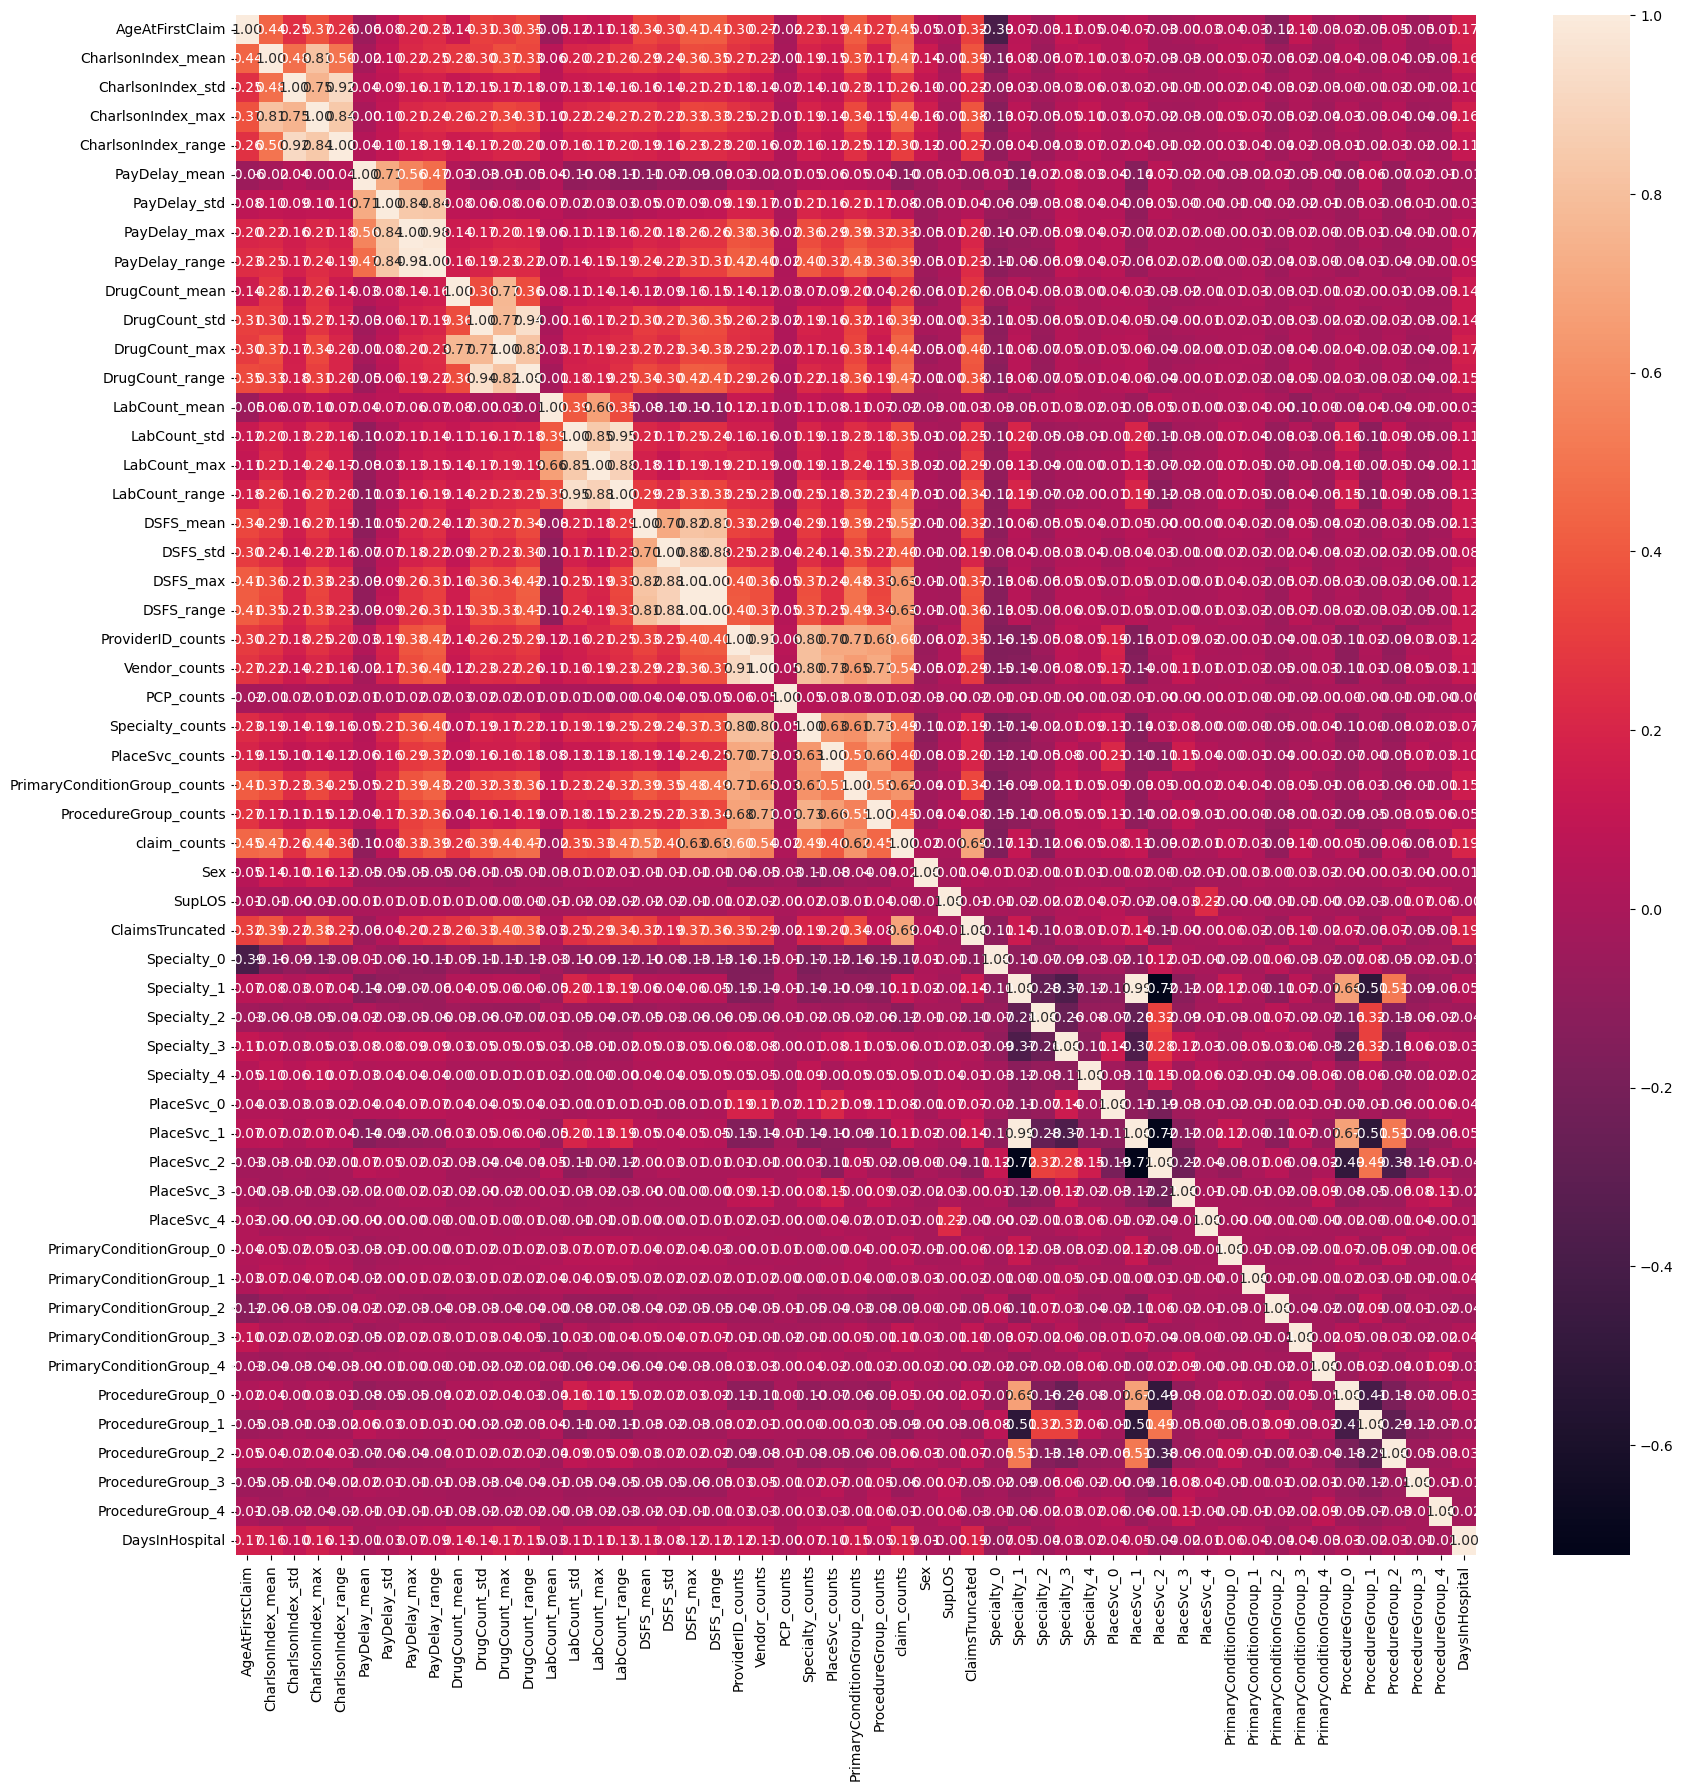

In [14]:
show_heatmap(data, figsize = (20,20))

In [6]:
data_config

{'num_cols': ['AgeAtFirstClaim',
  'CharlsonIndex_mean',
  'CharlsonIndex_std',
  'CharlsonIndex_max',
  'CharlsonIndex_range',
  'PayDelay_mean',
  'PayDelay_std',
  'PayDelay_max',
  'PayDelay_range',
  'DrugCount_mean',
  'DrugCount_std',
  'DrugCount_max',
  'DrugCount_range',
  'LabCount_mean',
  'LabCount_std',
  'LabCount_max',
  'LabCount_range',
  'DSFS_mean',
  'DSFS_std',
  'DSFS_max',
  'DSFS_range',
  'ProviderID_counts',
  'Vendor_counts',
  'PCP_counts',
  'Specialty_counts',
  'PlaceSvc_counts',
  'PrimaryConditionGroup_counts',
  'ProcedureGroup_counts',
  'claim_counts'],
 'cat_cols': ['Sex',
  'SupLOS',
  'ClaimsTruncated',
  'Specialty_0',
  'Specialty_1',
  'Specialty_2',
  'Specialty_3',
  'Specialty_4',
  'PlaceSvc_0',
  'PlaceSvc_1',
  'PlaceSvc_2',
  'PlaceSvc_3',
  'PlaceSvc_4',
  'PrimaryConditionGroup_0',
  'PrimaryConditionGroup_1',
  'PrimaryConditionGroup_2',
  'PrimaryConditionGroup_3',
  'PrimaryConditionGroup_4',
  'ProcedureGroup_0',
  'ProcedureGroup

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = df_claims_sample.drop(columns = [target])
y = df_claims_sample[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((16000, 52), (4000, 52))

In [8]:
from sklearn.linear_model import RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10]).fit(X_train, y_train)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)), np.sqrt(mean_squared_log_error(y_test, y_pred)))

3.2132797274389517 0.6089266051118257


In [9]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train[0:4000], y_train[0:4000])

y_pred = model.predict(X_test)

#print(np.sqrt(mean_squared_error(y_test, y_pred)), np.sqrt(mean_squared_log_error(y_test, y_pred)))

In [111]:
model = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, alpha=0.5, random_state=42, verbose=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

Iteration 1, loss = 6.82087277
Iteration 2, loss = 5.69104654
Iteration 3, loss = 5.63304946
Iteration 4, loss = 5.59641639
Iteration 5, loss = 5.56745411
Iteration 6, loss = 5.55463969
Iteration 7, loss = 5.53834689
Iteration 8, loss = 5.53046853
Iteration 9, loss = 5.49419914
Iteration 10, loss = 5.47376995
Iteration 11, loss = 5.45821641
Iteration 12, loss = 5.44598646
Iteration 13, loss = 5.43488891
Iteration 14, loss = 5.40403607
Iteration 15, loss = 5.39753257
Iteration 16, loss = 5.37505125
Iteration 17, loss = 5.35259636
Iteration 18, loss = 5.35113794
Iteration 19, loss = 5.33014822
Iteration 20, loss = 5.31714704
Iteration 21, loss = 5.28863856
Iteration 22, loss = 5.26969015
Iteration 23, loss = 5.26764518
Iteration 24, loss = 5.27877753
Iteration 25, loss = 5.24163384
Iteration 26, loss = 5.25022766
Iteration 27, loss = 5.21671302
Iteration 28, loss = 5.18975653
Iteration 29, loss = 5.17714451
Iteration 30, loss = 5.16469374
Iteration 31, loss = 5.14872359
Iteration 32, los